# 02: Bootstrapping confidence intervals
Previously, we saw how to obtain confidence intervals on our curve fit parameters using classical statistical distributions. As pointed out, that approach assumes the various fit parameters are *normally* distributed. That's often not the case with non-linear fits. The classical approach also assumes that uncertainty in your (y) data is evenly spread out among your (x) points. Again, particularly with non-linear fits, this is often not the case. We frequently have some areas with greater noise than others, so how do we retrieve confidence intervals that reflect this reality?

Here, we'll explore the *bootstrapping* approach. In short, this technique repeatedly fits the desired function to random subsets of your data to answer the question of how the fit would change in response to slight variation. This gives us a distribution of reasonable parameter values, from which we can determine the most likely value as well as get a sense of how skewed these reasonable values are in one direction or the other.
***

## Generating more realistic data
First, our usual imports and some synthetic data. I'll make this data a bit more complex than before, to illustrate a more likely scenario where experimental noise is not shared evenly among *x*-values. The details aren't important for this lesson, and largely arbitrary anyways, so skip ahead if you're uninterested. If you're curious, I took the same logistic Hill curve from before, normalized it so it fell between 0 and 1, then took the *logit* transform. This transform takes data bounded on (0,1) and puts them on an unbounded *log* scale. By applying Gaussian noise here then transforming the data back to "normal" space, I ensure the greatest noise lies at the midpoint of the curve (where it's steepest, as we'd expect) and that noise at the extremes tends towards the center slightly (again, as we'd expect from real data).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import scipy.optimize as opt
np.random.seed(42)           # For reproducibility

In [2]:
def logit(x):
    return np.log(x/(1-x))

def logit_inv(y):
    return 1/(np.exp(-y)+1)

def Hill_eq(x,S0,Smax,x_crit,b):
    return S0 + ( Smax - S0 )/( 1 + 10**((x_crit-x)*b) )

def normalize(y,span):
    return np.interp(y,(y.min(),y.max()),(0.5-span/2,0.5+span/2))

def unnormalize(norm_y,span,y):
    return np.interp(norm_y,(0.5-span/2,0.5+span/2),(y.min(),y.max()))
    

c = concentrations = 10**-np.arange(5.,12.)
lg_c = np.log10(c)

p_Hill = [0.3,1.5,-8,1.4]
r = response = Hill_eq(lg_c,*p_Hill)

xpts = np.linspace(lg_c.min(),lg_c.max(),100)
ypts = Hill_eq(xpts,*p_Hill)

span = 0.9

logit_r = logit(normalize(r,span))

n_reps = 10

logit_data = np.array([np.random.normal(l_r,0.5,size = n_reps) for l_r in logit_r])
data = unnormalize(logit_inv(logit_data),span,r)

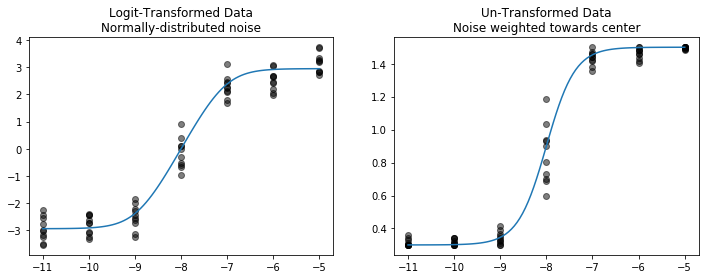

In [3]:
_, axs = plt.subplots(1,2,figsize=(12,4))

axs[0].plot(lg_c,logit_data,'o',color='k',alpha = 0.5)
axs[0].plot(xpts,logit(normalize(ypts,span)))
axs[0].set_title('Logit-Transformed Data'+'\n'+'Normally-distributed noise')

axs[1].plot(lg_c,data,'o',color='k',alpha = 0.5)
axs[1].plot(xpts,ypts)
axs[1].set_title('Un-Transformed Data'+'\n'+'Noise weighted towards center');

***
## Classical confidence intervals
Let's first fit this curve as before with classical confidence intervals. The functions we defined last time are now in the BenchtopUtils.py file; by placing the file next to this one in our directory, we can import it and use the functions it contains just like any other module.

,S0,Smax,x_crit,Hill Coefficient
95% CI Lower Limit,0.340857,1.505824,-7.646232,1.930453
Optimal Value,0.314524,1.495506,-7.913228,1.387373
95% CI Upper Limit,0.288192,1.485187,-8.180224,0.844294
Standard Error,0.013435,0.005265,0.136225,0.277086


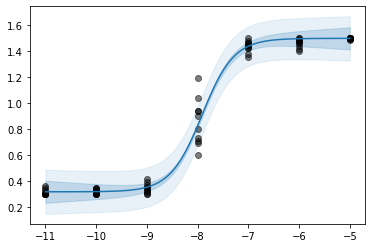

In [4]:
import BenchtopUtils as bu

S0_g = data.min()
Smax_g = data.max()
x_crit_g = lg_c[np.argmax(data[:,0] < (Smax_g-S0_g)/2+S0_g)]
b_g = 1
guesses = (S0_g, Smax_g, x_crit_g, b_g)

p_opt, p_cov = opt.curve_fit(Hill_eq, lg_c, data.mean(1),sigma = data.std(1), absolute_sigma = True)

y_fit = Hill_eq(xpts,*p_opt)

ci, pi = bu.classical_fit_intervals(Hill_eq,p_opt,lg_c,data,xpts)

plt.plot(lg_c,data,'o',color='k',alpha = 0.5)
plt.plot(xpts,y_fit)
plt.fill_between(xpts, y_fit-ci, y_fit+ci, color = 'C0', alpha = 0.2)
plt.fill_between(xpts, y_fit-pi, y_fit+pi, color = 'C0', alpha = 0.1)

Hill_params = ('S0','Smax','x_crit','Hill Coefficient')

bu.classical_fit_param_summary(p_opt,p_cov, names = Hill_params)

If you look at the confidence intervals we get from this classical approach, you should notice that the shape is not quite what we'd expect. The data is tightest at the ends of the curve, yet that's where the CI is the widest. Conversely, the middle of the curve, where the data is noisiest, has the tightest CI. This is because the classical approach only takes into account the total spread in your data, and assumes that uncertainty is shared evenly along all points of the curve. Clearly this does not reflect the data.

***
## Bootstrapped confidence intervals
The bootstrapping approach is based on random resampling of your dataset. It's based on the principle that the noise in our data is based in part on random chance, so we were just as likely to have observed a slightly different dataset than the one we did. Bootstrapping generates random subsets of your data then fits the curve to this synthetic dataset. By repeating this hundreds or thousands of times, we can get a sense of how the fit parameters vary with subtle shifts in the data.

### Slightly different data
Let's first try this with a single synthetic dataset. First we fit the curve to our data as before, obtaining the *residuals*, or the distance between the predicted *y*-value and the actual *y*-value(s).

In [5]:
y_fit = Hill_eq(lg_c,*p_opt)

Because our predicted *y*-values `y_fit` are in a single, 1-dimensional vector but our data is a matrix (with seven rows and ten columns), we need to replicate our predicted data with `tile` so that it's the same shape as our observed data.

In [6]:
print('Shape of observed data: {:}'.format(data.shape))
print('Shape of predicted values: {:}'.format(y_fit.shape))
y_fit = np.tile(y_fit,[data.size//lg_c.size,1]).T
print('New shape of tiled predictions: {:}'.format(y_fit.shape))
resid = data - y_fit # Residuals

Shape of observed data: (7, 10)
Shape of predicted values: (7,)
New shape of tiled predictions: (7, 10)


Next, we'll go through each *x* value and randomly choose from the residuals at that point to generate our synthetic dataset. The key here is we are "sampling with *replacement*", meaning we can choose the same value multiple times. We'll keep the number of data points at each *x* the same. for brevity, we'll use a __[*list comprehension*](https://www.pythonforbeginners.com/basics/list-comprehensions-in-python)__ to step through each row of our data and randomly pick from the corresponding residuals. Then we'll add these sampled residuals to our predicted *y* values to generate our synthetic dataset.

In [7]:
resid_resamples = np.array([np.random.choice(resid[row], size = resid[row].size) for row in range(len(lg_c))])
new_y = y_fit+resid_resamples

Now `new_y` is our new, synthetic dataset. Let's fit the same curve as above and look at the new fit parameters in `p_strapped` to see how they differ.

Fit parameters for original data:


,S0,Smax,x_crit,Hill Coefficient
95% CI Lower Limit,0.340857,1.505824,-7.646232,1.930453
Optimal Value,0.314524,1.495506,-7.913228,1.387373
95% CI Upper Limit,0.288192,1.485187,-8.180224,0.844294
Standard Error,0.013435,0.005265,0.136225,0.277086


Fit parameters for synthetic (resampled) data:


,S0,Smax,x_crit,Hill Coefficient
95% CI Lower Limit,0.338496,1.507047,-7.653262,1.710970
Optimal Value,0.314364,1.496777,-7.838852,1.312372
95% CI Upper Limit,0.290233,1.486507,-8.024442,0.913773
Standard Error,0.012312,0.005240,0.094690,0.203370


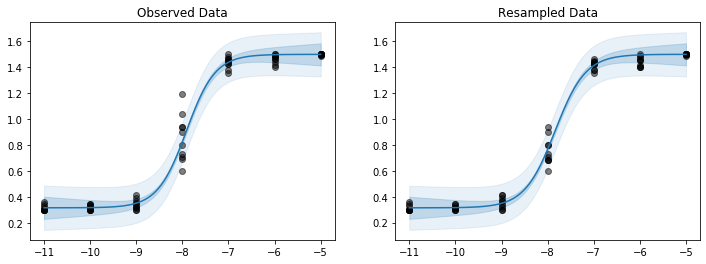

In [8]:
fig, axs = plt.subplots(1,2,figsize = (12,4))
axs[0].plot(lg_c,data,'o',color='k',alpha = 0.5)
axs[0].plot(xpts,Hill_eq(xpts,*p_opt))
axs[0].fill_between(xpts, Hill_eq(xpts,*p_opt)-ci, Hill_eq(xpts,*p_opt)+ci, color = 'C0', alpha = 0.2)
axs[0].fill_between(xpts, Hill_eq(xpts,*p_opt)-pi, Hill_eq(xpts,*p_opt)+pi, color = 'C0', alpha = 0.1)
axs[0].set_title('Observed Data')
print('Fit parameters for original data:')
classical_summary = bu.classical_fit_param_summary(p_opt,p_cov, names = ('S0','Smax','x_crit','Hill Coefficient'))
display(classical_summary)


p_strapped, cov_strapped = opt.curve_fit(Hill_eq, lg_c, new_y.mean(1), sigma = new_y.std(1), absolute_sigma = True)
curve_strapped = Hill_eq(xpts,*p_strapped)

ci, pi = bu.classical_fit_intervals(Hill_eq,p_opt,lg_c,data,xpts)

axs[1].plot(lg_c,new_y,'o',color='k',alpha = 0.5)
axs[1].plot(xpts,curve_strapped)
axs[1].fill_between(xpts, curve_strapped-ci, curve_strapped+ci, color = 'C0', alpha = 0.2)
axs[1].fill_between(xpts, curve_strapped-pi, curve_strapped+pi, color = 'C0', alpha = 0.1)
axs[1].set_title('Resampled Data')

print('Fit parameters for synthetic (resampled) data:')
display(bu.classical_fit_param_summary(p_strapped,cov_strapped, names = ('S0','Smax','x_crit','Hill Coefficient')))

As expected, the fit parameters shifted slightly with the new dataset. 

### Making sure synthetic data is realistic

There's a catch here. Some of our random choices will result in a row of "replicates" that are all identical. In this case, the standard deviation at this *x*-point will be zero, which will confuse the `curve_fit` algorithm as it will try to force the curve through this point exactly. Each iteration, we need to make sure we don't have any rows in `resid_resamples` that contain only a single value. We'll take a slightly roundabout way to do this as consisely as possible.

First, we'll convert the row (a Numpy array) to a __[*set*](https://snakify.org/en/lessons/sets/)__. A set is simply a list that can only contain unique values. If we try to convert a list of values with duplicates into a *set*, the duplicates are discarded. Thus, by taking the *length* of a set derived from a row in our array, we can tell how many unique values that row contains. If the length of the resulting set is exactly 1, we know that row contained only a single value. We'll use python's `all` functionality to make sure that every row in `resid_resamples` has at least two unique values. In the full bootstrapping `for` loop, we'll use a `while` loop within each iteration to keep sampling the residuals until we get a sample that passes this test.

In [9]:
print( 'The original row:' )
print( resid_resamples[0] )
print()
print( 'The set of unique values derived from that row:' )
print( set(resid_resamples[0]) )
print()
print( 'Length of that set:' )
print( len(set(resid_resamples[0])) )
print()
print( 'Is that set longer than 1?' )
print( len(set(resid_resamples[0])) > 1 )
print()
print( 'Is the set of unique values derived from each row longer than 1?' )
print( [len(set(resid_resamples[row])) > 1 for row in range(len(lg_c))] )
print()
print( 'Do all rows contain at least two unique values?' )
print( all(len(set(resid_resamples[row])) > 1 for row in range(len(lg_c))) )

The original row:
[ 0.00452597 -0.00329085  0.00452597  0.00452597  0.00452597 -0.01200967
  0.00452597  0.00452597  0.00452597  0.00452597]

The set of unique values derived from that row:
{0.004525971727739275, -0.0032908481333291384, -0.012009671259540111}

Length of that set:
3

Is that set longer than 1?
True

Is the set of unique values derived from each row longer than 1?
[True, True, True, True, True, True, True]

Do all rows contain at least two unique values?
True


### (Nearly) Every possible permutation

Now for the true bootstrapping method, let's repeat this process a few hundred or thousand times and leverage the power of large numbers to get a real sense of our distributions. I'll use the `tqdm` module here (named for the Arabic word for progress), which simply provides a nice progress bar for a `for` loop when you wrap it around the iterator (here, `range`). Because we're drawing *so* many samples, bootstrapping can take a little time, so it's nice to have an idea of how long you'll have to wait for it to finish. On my machine, 10000 iterations takes about 16 seconds.

Note that here it is crucial to provide initial parameter guesses to `curve_fit` each iteration for it to converge quickly. On my machine, it's nearly a *five-fold* improvement in speed: the `for` loop processes about 600 iterations per second if I provide initial guesses, compared to 120 iterations per second if I don't. Additionally, if you don't provide updated guesses based on each synthetic dataset, the fitting algorithm may fail to converge at all.

In [10]:
from tqdm import tqdm                    # Use for JupyterLab or Spyder
#from tqdm import tqdm_notebook as tqdm  # Use for classic Jupyter

n_straps= 10000
p_strapped = np.zeros([n_straps,p_opt.size])    # Create a matrix of zeros to store the parameters from each bootstrap iteration
curve_strapped = np.zeros([n_straps,xpts.size]) # Another matrix to store the predicted curve for each iteration

for i in tqdm(range(n_straps)):
    
    invalid_sample = True
    while invalid_sample:
        resid_resamples = np.array([np.random.choice(resid[row],size = resid[row].size) for row in range(len(lg_c))])
        if all(len(set(resid_resamples[row])) > 1 for row in range(len(lg_c))): invalid_sample = False
            
    new_y = y_fit+resid_resamples

    S0_g = new_y.min()
    Smax_g = new_y.max()
    x_crit_g = lg_c[np.argmax(new_y[:,0] < (Smax_g-S0_g)/2+S0_g)]
    b_g = 1
    guesses = (S0_g, Smax_g, x_crit_g, b_g)
    
    p_strapped[i], _ = opt.curve_fit(Hill_eq, lg_c, new_y.mean(1), sigma = new_y.std(1), absolute_sigma = True, p0 = guesses)
    curve_strapped[i] = Hill_eq(xpts,*p_strapped[i])

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 579.33it/s]


Now that we have 10000 variations on our curve fit, determining the CI for our curve is as simple as finding the appropriate percentile at each point. Here, we'll plot the true underlying curve, the original "optimal" fit, and the median curve from our distribution. Let's compare it to the classical CIs.

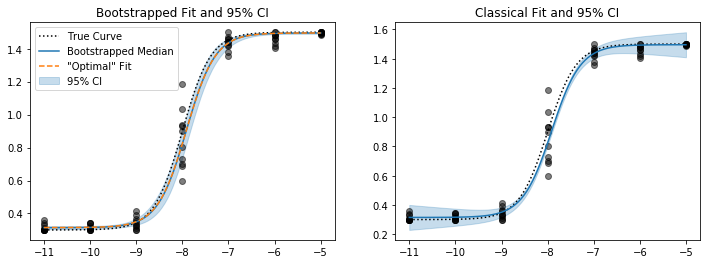

In [11]:
CI = 95

c_lower = np.percentile(curve_strapped,(100+CI)/2,axis = 0)
c_median = np.percentile(curve_strapped,50,axis = 0)
c_upper = np.percentile(curve_strapped,(100-CI)/2,axis = 0)

fig, axs = plt.subplots(1,2,figsize = (12,4))

axs[0].plot(lg_c,data,'o',color='k',alpha = 0.5)
axs[0].plot(xpts,Hill_eq(xpts,*p_Hill), 'k:', label = 'True Curve')

median = axs[0].plot(xpts, c_median, color = 'C0', label = 'Bootstrapped Median')
axs[0].fill_between(xpts, c_upper, c_lower, color = plt.getp(median[0],'color'), alpha = 0.25, label = '{:}% CI'.format(CI))
axs[0].plot(xpts,Hill_eq(xpts,*p_opt), ls = '--', color = 'C1', label = '"Optimal" Fit')
axs[0].legend()
axs[0].set_title('Bootstrapped Fit and 95% CI')

axs[1].plot(lg_c,data,'o',color='k',alpha = 0.5)
axs[1].plot(xpts,Hill_eq(xpts,*p_Hill), 'k:')
axs[1].plot(xpts,Hill_eq(xpts,*p_opt))
axs[1].fill_between(xpts, Hill_eq(xpts,*p_opt)-ci, Hill_eq(xpts,*p_opt)+ci, color = 'C0', alpha = 0.25)
axs[1].set_title('Classical Fit and 95% CI');

The first difference you should notice is that the bootstrapped CIs follow our intuition better than the classical CIs do: the confidence interval is wide in regions with more noise in the underlying data (the middle of the curve) and narrow in regions with tightly clustered observed data. Because the classical approach assumes the same "shape" of the CI profile regardless of the underlying data or model, it presents us with the same narrow waist and wide extremes that it did for the simple linear fit we performed in the previous tutorial.

Also, we can see that the "optimal" and median curves overlap more or less exactly in our bootstrapped model. Our 95% CI is also notably asymmetrical in *x* around the median value. This is the power of the bootstrap method: it makes no assumptions about your data and so can detect when slight variations have asymmetrical impacts on the fit. Both fits, however, deviate from the true curve, which at many point appears to lie at the extreme of the 95% CI or even beyond. This is an important point to remember about CIs: they represent how close the fit is to the *data*, not how close the fit (or the data) is to the underlying *model*.

Let's look at the 95% CIs on our parameter values as well and see how they compare to the classical method. 

In [12]:
p_upper = np.percentile(p_strapped,(100+CI)/2,axis = 0)
p_median = np.percentile(p_strapped,50,axis = 0)
p_lower = np.percentile(p_strapped,(100-CI)/2,axis = 0)

boot_summary = pd.DataFrame(data = [p_lower,p_median,p_upper],
                            index = ('{:}% CI Lower Limit'.format(CI),'Median Value','{:}% CI Upper Limit'.format(CI)),
                            columns = Hill_params)
print('Classical fit parameter intervals:')
display(classical_summary)
print()
print('Bootstrapped fit parameter intervals:')
display(boot_summary)

Classical fit parameter intervals:


,S0,Smax,x_crit,Hill Coefficient
95% CI Lower Limit,0.340857,1.505824,-7.646232,1.930453
Optimal Value,0.314524,1.495506,-7.913228,1.387373
95% CI Upper Limit,0.288192,1.485187,-8.180224,0.844294
Standard Error,0.013435,0.005265,0.136225,0.277086



Bootstrapped fit parameter intervals:


,S0,Smax,x_crit,Hill Coefficient
95% CI Lower Limit,0.304029,1.491003,-8.003151,1.223979
Median Value,0.313482,1.495539,-7.913549,1.394889
95% CI Upper Limit,0.322878,1.499021,-7.826359,1.645520


Again, pay attention to the symmetry (or lack thereof) in the fit intervals about the median. The median of the Hill Coefficienct is much closer to the 2.5%ile than the 97.5%ile.

We can even take this a step further. We have 10000 data points representing reasonable values for each parameter, allowing us to visualize the entire distribution. We'll use the `seaborn` library to help us here, because it contains functions that make it easy to view distributions. In particular, the `distplot` function shows us a histogram with a *Kernel Density Estimate* (KDE) overlain on top. KDEs circumvent many of the problems posed by histograms, as explained __[here](https://seaborn.pydata.org/tutorial/distributions.html)__. Among other advantages, it allows us to get a robust modal value for our paramter (maximum of the KDE). The choice between whether the modal or median value of a paramater is more representative is largely philosophical and will likely depend on the use case, but they differ signifiantly only for highly skewed distributions, and both are less sensitive to outliers than the mean. 

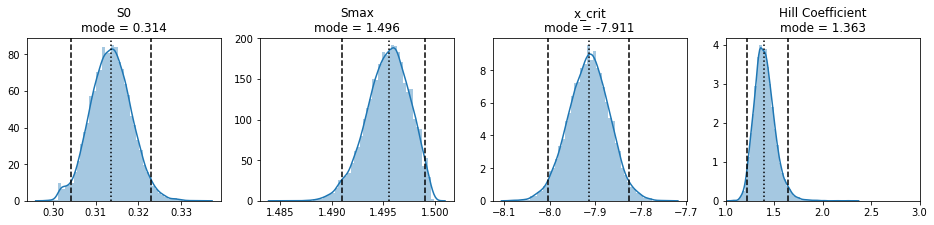

In [13]:
import seaborn as sns

# Rarely, the Hill coefficient obtains very large values, ~6, which make the plot difficult to see. Let's get rid of all values greater than 3
censor = p_strapped[:,-1] > 3
p_strapped[censor,-1] = np.nan

_,n_p = p_strapped.shape
mode = np.zeros([n_p,])

fig, axs = plt.subplots(1, n_p, figsize = (4*n_p,3))
for p in range(n_p):
    param = p_strapped[:,p]
    valid_param = param[~np.isnan(param)]
    sns.distplot(valid_param, ax = axs[p])
    axs[p].axvline(np.percentile(valid_param, (100-CI)/2, axis = 0), ls = '--', color = 'k')
    axs[p].axvline(np.percentile(valid_param, 50, axis = 0), ls = ':', color = 'k')
    axs[p].axvline(np.percentile(valid_param, (100+CI)/2, axis = 0), ls = '--', color = 'k')

    KDE = axs[p].get_children()[-14]
    mode[p] = KDE.get_xdata()[np.argmax(KDE.get_ydata())]

    axs[p].set_title(Hill_params[p] + '\n' + 'mode = {:.3f}'.format(mode[p]))
    
axs[-1].set_xlim([1,3]); 

***
## Portable functions
Finally, let's wrap all of these operations into flexible functions that we can use for any curve. We'll let the bootstrapping function itself be flexible to different input sizes and shapes (replicating and reshaping the *x* or *y* data appropriately), different methods of determining initial guesses from each synthetic dataset, as well as different approaches to the resampling itself. The approach outlined above is one that I would consider *conservative* or *non-parametric*, becuase it only samples directly from the observed data, and *piecewise* or *local*, becuase it only chooses new residuals at each *x* from the residuals actually observed at that *x*. Other approaches, which I would term *non-conservative* or *parametric*, fit a normal distribution to the residuals, then sample that normal distribution. Additionally, others choose new residuals from the total pool of residuals observed anywhere along the curve. This *non-piecewise* or *global* approach is ideal if you have only one *y* for every *x*, e.g. time-series or spectral data, in which case the piecewise approach would be non-sensical.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import scipy.optimize as opt
import seaborn as sns
from tqdm import tqdm#_notebook as tqdm

# Performing the bootstrap algorithm
def bootstrap_fits(func, x, y, p_opt, n_straps = 1000, res = 100, xpts = None, guess_gen = None,
                 fit_kws = {}, conservative = True, piecewise = True):
    # If y is a vector of length 'm', x must also be a vector of length 'm'
    # If y is a matrix of shape 'm x n', with replicates in different columns, x must either be a vector of length 'm' or a matrix of shape 'm x n'
    
    # Number of unique x values
    n = len(set(x))
    
    # Number of replicates
    m = y.size//n
    
    # Piecewise bootstrapping is nonsensical if there's only one y per x
    if y.ndim == 1: piecewise = False
    
    # Generate points at which to evaluate the curves
    if xpts is None: xpts = np.linspace(x.min(),x.max(),res)
    elif xpts.size == 2: xpts = np.linspace(xpts[0],xpts[1],res)

    # Predicted y values
    y_fit = func(x,*p_opt)
    
    # Tile the predicted y values if necessary so that they're the same shape as the original data
    if y_fit.shape != y.shape: y_fit = np.tile(y_fit,[y.size//x.size,1]).T
        
    # Get the residuals (and they're )
    resid = y - y_fit
    
    p_strapped = np.zeros([n_straps,p_opt.size])    # Create a matrix of zeros to store the parameters from each bootstrap iteration
    curve_strapped = np.zeros([n_straps,xpts.size]) # Another matrix to store the predicted curve for each iteration
    
    for i in tqdm(range(n_straps)):
        
        # Choose new residuals based on the specified method
        if piecewise and conservative:
            invalid_sample = True
            while invalid_sample:
                resid_resamples = np.array([np.random.choice(resid[row],size = m) for row in range(n)])
                if all(len(set(resid_resamples[row])) > 1 for row in range(n)): invalid_sample = False
                    
        elif piecewise and not conservative:
            sigma_resid = [resid[row].std() for row in range(n)]
            resid_resamples = np.array([np.random.normal(0, size = m) for row in range(n)])
        elif not piecewise and not conservative:
            sigma_resid = resid.std()
            resid_resamples = np.random.normal(0, sigma_resid, size = resid.shape)
            
        elif not piecewise and conservative:
            resid_resamples = np.random.choice(resid.flat, size = resid.shape)
                
        # Generate a synthetic dataset from the sampled residuals
        new_y = y_fit+resid_resamples
        
        if guess_gen is not None:
            # Generate guesses for this dataset
            guesses = guess_gen(lg_c,new_y)
        else:
            # Default guesses
            guesses = np.ones(len(p_opt))
        
        # Additional keyword arguments to curve_fit can be passed as a dictionary via fit_kws
        if y.ndim == 1:
            p_strapped[i], _ = opt.curve_fit(func, x, new_y,
                                             p0 = guesses,
                                             **fit_kws)
        else:
            p_strapped[i], _ = opt.curve_fit(func, x, new_y.mean(1),
                                             sigma = new_y.std(1), absolute_sigma = True,
                                             p0 = guesses,
                                             **fit_kws)
        
        curve_strapped[i] = func(xpts,*p_strapped[i])
    
    return p_strapped, curve_strapped

# Plot the bootstrapped curve and its confidence intervals
def bootstrap_plot(xpts,bootstrap_curves, CI = 95, line_kws ={},fill_kws={}):
    c_lower = np.percentile(bootstrap_curves,(100-CI)/2,axis = 0)
    c_median = np.percentile(bootstrap_curves,50,axis = 0)
    c_upper = np.percentile(bootstrap_curves,(100+CI)/2,axis = 0)
    
    # Additional keyword arguments to plot or fill_between can be passed as a dictionary via line_kws and fill_kws, respectively
    med = plt.plot(xpts, c_median, **line_kws)
    ci = plt.fill_between(xpts, c_upper, c_lower, color = plt.getp(med[0],'color'), alpha = 0.25, **fill_kws)
    return med, ci

# Summarize parameters and confidence intervals resulting from the bootstrap algorithm
def bootstrap_summary(bootstrap_params, CI = 95, names = None):
    p_lower = np.percentile(bootstrap_params,(100-CI)/2,axis = 0)
    p_median = np.percentile(bootstrap_params,50,axis = 0)
    p_upper = np.percentile(bootstrap_params,(100+CI)/2,axis = 0)
    
    summary = pd.DataFrame(data = [p_lower,p_median,p_upper],
                       index = ('{:}% CI Lower Limit'.format(CI),'Median Value','{:}% CI Upper Limit'.format(CI)),
                       columns = names)
    return summary  

# Plot the bootstrapped distributions for each parameter and label with the modal value derived from its KDE
def bootstrap_dists(bootstrap_params, CI = 95, names = None, rug_kws = {}, kde_kws = {}):
    _,n_p = bootstrap_params.shape
    mode = np.zeros([n_p,])
    
    fig, axs = plt.subplots(1, n_p, figsize = (4*n_p,3))
    for p in range(n_p):
        sns.distplot(bootstrap_params[:,p], ax = axs[p], **rug_kws, **kde_kws)
        axs[p].axvline(np.percentile(bootstrap_params[:,p], (100-CI)/2, axis = 0), ls = '--', color = 'k')
        axs[p].axvline(np.percentile(bootstrap_params[:,p], 50, axis = 0), ls = ':', color = 'k')
        axs[p].axvline(np.percentile(bootstrap_params[:,p], (100+CI)/2, axis = 0), ls = '--', color = 'k')

        KDE = axs[p].get_children()[-14]
        mode[p] = KDE.get_xdata()[np.argmax(KDE.get_ydata())]
        
        axs[p].set_title(names[p] + '\n' + 'mode = {:.3f}'.format(mode[p]))
        
    return fig, axs, mode

Define our "guess generator" and then run the bootstrap.

In [15]:
def Hill_guesses(x,y):
    S0_g = y.min()
    Smax_g = y.max()
    x_crit_g = x[np.argmax(y[:,0] < (Smax_g-S0_g)/2+S0_g)]
    b_g = 1
    return (S0_g, Smax_g, x_crit_g, b_g)

p_strapped, curve_strapped = bootstrap_fits(Hill_eq, lg_c, data, p_opt, n_straps = 10000, guess_gen = Hill_guesses)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 660.32it/s]


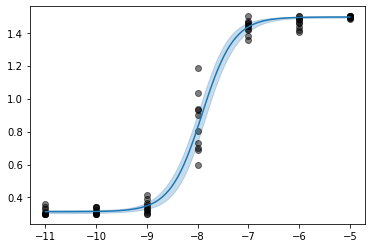

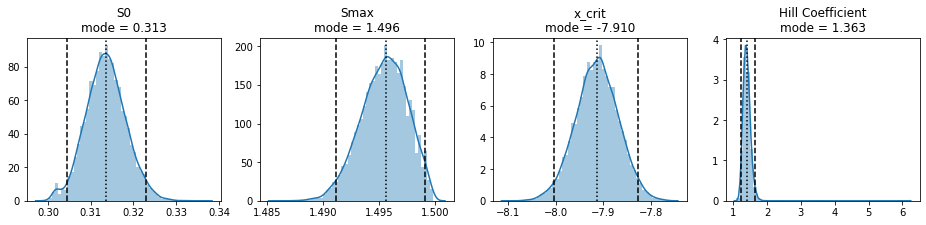

In [16]:
plt.plot(lg_c,data,'o',color='k',alpha = 0.5)

bootstrap_plot(xpts,curve_strapped);
bootstrap_dists(p_strapped, names = ('S0','Smax','x_crit','Hill Coefficient'));

In [17]:
display(bootstrap_summary(p_strapped, names = ('S0','Smax','x_crit','Hill Coefficient')))

,S0,Smax,x_crit,Hill Coefficient
95% CI Lower Limit,0.304415,1.491175,-8.003237,1.222785
Median Value,0.313476,1.495548,-7.912881,1.393415
95% CI Upper Limit,0.322906,1.499036,-7.826646,1.635716
